In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor

import pickle
import json

import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Bengaluru_House_Data.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


# Data
## Data cleaning

In [3]:
df.shape

(13320, 9)

In [4]:
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [5]:
df2 = df.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [6]:
df2.isna().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [7]:
df3 = df2.dropna()
df3.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [8]:
df3.shape

(13246, 5)

In [9]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [10]:
df3['BHK'] = df3['size'].apply(lambda x: int(x.split()[0]))

In [11]:
df3.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [12]:
df3.dtypes

location       object
size           object
total_sqft     object
bath          float64
price         float64
BHK             int64
dtype: object

In [13]:
def is_float(x: str) -> bool:
    try:
        float(x)
        return True

    except (ValueError, TypeError):
        return False

In [14]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,BHK
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [15]:
def convert_sqft_to_num(sqft: float | str) -> float | None:
    try:
        return float(sqft)

    except (ValueError, TypeError):
        try:
            num1, num2 = sqft.split('-')
            num1, num2 = float(num1), float(num2)

            return (num1 + num2) / 2

        except (AttributeError, ValueError):
            return None


In [16]:
df4 = df3.copy()

In [17]:
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)

In [18]:
df4 = df4.drop(['size'], axis='columns')
df4 = df4.dropna()

In [19]:
df4.dtypes

location       object
total_sqft    float64
bath          float64
price         float64
BHK             int64
dtype: object

In [20]:
df4.head()

,location,total_sqft,bath,price,BHK
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


## Feature Engineering

In [21]:
df5 = df4.copy()

In [22]:
df5['price_per_sqrt'] = (df5['price'] * 100000) / df5['total_sqft']
df5.head()

,location,total_sqft,bath,price,BHK,price_per_sqrt
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [23]:
df5['location'].unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [24]:
df5['location'] = df5['location'].apply(lambda x: x.strip())

In [25]:
df5['location'].unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [26]:
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               533
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           264
Thanisandra              235
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Kannur                     1
whitefiled                 1
Name: location, Length: 1287, dtype: int64

In [27]:
location_stats_less_than_10 = location_stats[location_stats <= 10]
location_stats_less_than_10

location
Sadashiva Nagar          10
Naganathapura            10
Basapura                 10
Nagadevanahalli          10
Kalkere                  10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Kannur                    1
whitefiled                1
Name: location, Length: 1047, dtype: int64

In [28]:
len(df5['location'].unique())

1287

In [29]:
df5['location'] = df5['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

In [30]:
len(df5['location'].unique())

241

In [31]:
df5.head()

,location,total_sqft,bath,price,BHK,price_per_sqrt
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


## Outlier Removal

In [32]:
def remove_outliers(df: pd.DataFrame, numeric_columns: list[str] = None, groupby_column: str = None):
    # Initialize an empty DataFrame to store the filtered results
    filtered_df = pd.DataFrame()

    if numeric_columns is None:
        # Get the numeric columns
        numeric_columns = df.select_dtypes(include=['number'])

    if groupby_column is not None:
        df.groupby(groupby_column)

    # Iterate through each column
    for column in df.columns:
        if column in numeric_columns:
            # Apply the condition to the numeric column and filter the series
            filtered_col = df[column][
                (df[column] >= df[column].quantile(0.1)) & (df[column] <= df[column].quantile(0.9))]

            # Concatenate the filtered column with the filtered_df
            filtered_df = pd.concat([filtered_df, filtered_col], axis='columns')

        else:
            # Concatenate the skipped column with the filtered_df
            filtered_df = pd.concat([filtered_df, df[column]], axis='columns')

    filtered_df = filtered_df.dropna()

    return filtered_df


In [33]:
df5.describe()

,total_sqft,bath,price,BHK,price_per_sqrt
count,13200.000000,13200.000000,13200.000000,13200.000000,1.320000e+04
mean,1555.302783,2.691136,112.276178,2.800833,7.920759e+03
std,1237.323445,1.338915,149.175995,1.292843,1.067272e+05
min,1.000000,1.000000,8.000000,1.000000,2.678298e+02
25%,1100.000000,2.000000,50.000000,2.000000,4.267701e+03
50%,1275.000000,2.000000,71.850000,3.000000,5.438331e+03
75%,1672.000000,3.000000,120.000000,3.000000,7.317073e+03
max,52272.000000,40.000000,3600.000000,43.000000,1.200000e+07


In [34]:
df6 = remove_outliers(df5, numeric_columns=['price_per_sqrt', 'price'], groupby_column='location')

df6.describe()

,total_sqft,bath,price,BHK,price_per_sqrt
count,9477.000000,9477.000000,9477.000000,9477.000000,9477.000000
mean,1426.207532,2.527171,82.859079,2.651789,5775.192994
std,483.770384,0.954663,38.158742,0.928473,1681.496910
min,360.000000,1.000000,38.000000,1.000000,3500.269833
25%,1140.000000,2.000000,55.000000,2.000000,4500.000000
50%,1299.000000,2.000000,70.000000,3.000000,5411.764706
75%,1607.000000,3.000000,100.000000,3.000000,6648.936170
max,6000.000000,15.000000,220.000000,14.000000,11666.666667


In [35]:
def plot_scatter_chart(df, location):
    df = df[(df['location'] == location) & (df['BHK'].isin([2, 3]))]

    ax = plt.axes()

    sn.scatterplot(df, x='total_sqft', y='price', hue='BHK', ax=ax)

    ax.set_title(location)


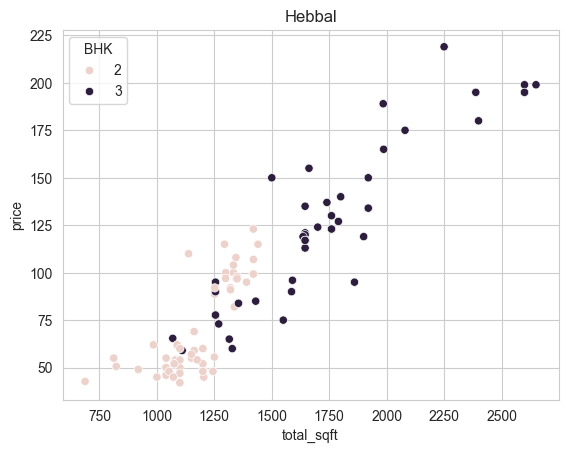

In [36]:
plot_scatter_chart(df6, "Hebbal")

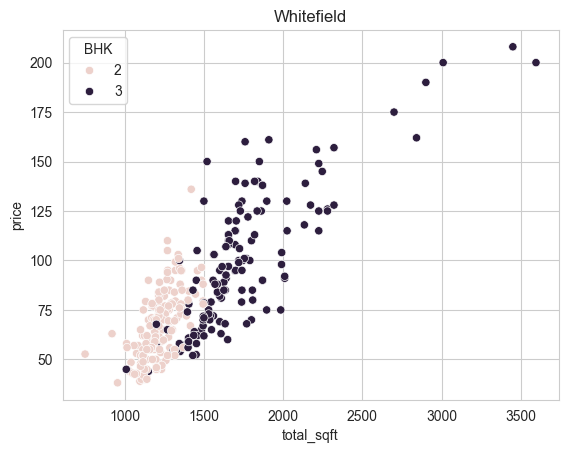

In [37]:
plot_scatter_chart(df6, "Whitefield")

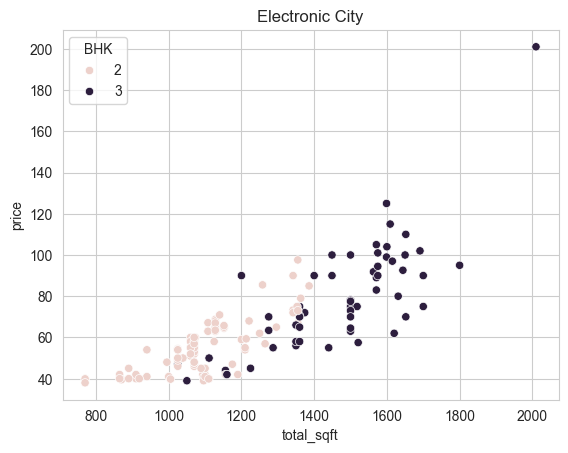

In [38]:
plot_scatter_chart(df6, "Electronic City")

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.

    {
        '1' : {
            'mean': 4000,
            'std: 2000,
            'count': 34
        },
        '2' : {
            'mean': 4300,
            'std: 2300,
            'count': 22
        },
    }

Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [39]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])

    for location, location_df in df.groupby('location'):
        bhk_stats = {}

        for bhk, bhk_df in location_df.groupby('BHK'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df['price_per_sqrt']),
                'std': np.std(bhk_df['price_per_sqrt']),
                'count': bhk_df.shape[0]
            }

        for bhk, bhk_df in location_df.groupby('BHK'):
            stats = bhk_stats.get(bhk - 1)

            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices,
                                            bhk_df[bhk_df['price_per_sqrt'] < (stats['mean'])].index.values)

    return df.drop(exclude_indices, axis='index')

In [40]:
df7 = remove_bhk_outliers(df6)

In [41]:
df7.describe()

,total_sqft,bath,price,BHK,price_per_sqrt
count,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000
mean,1401.123714,2.522326,88.090836,2.605647,6219.498429
std,470.948586,1.001534,40.555333,0.982545,1779.629620
min,360.000000,1.000000,38.000000,1.000000,3500.408831
25%,1120.000000,2.000000,55.000000,2.000000,4874.651811
50%,1260.000000,2.000000,78.000000,2.000000,5971.810089
75%,1620.000000,3.000000,110.000000,3.000000,7186.948854
max,6000.000000,15.000000,220.000000,14.000000,11666.666667


In [42]:
df7.shape

(6517, 6)

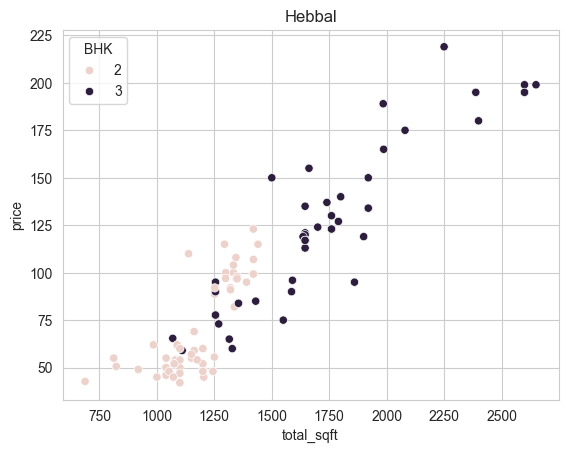

In [43]:
plot_scatter_chart(df6, "Hebbal")

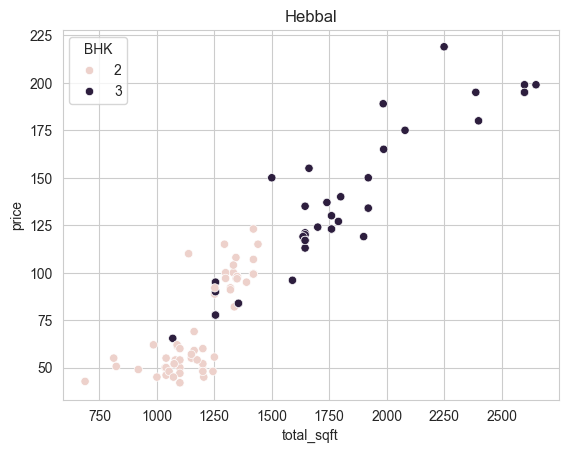

In [44]:
plot_scatter_chart(df7, "Hebbal")

<Axes: xlabel='price_per_sqrt', ylabel='Count'>

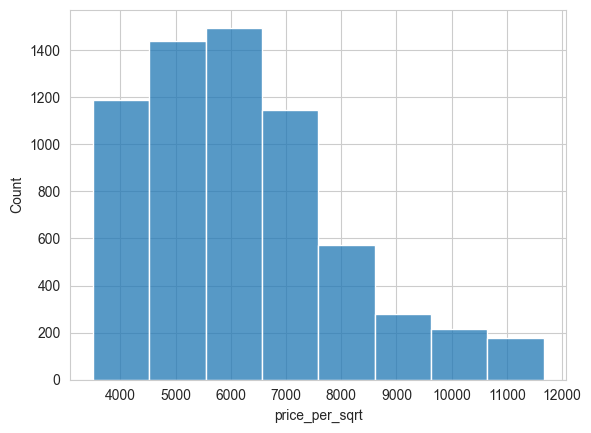

In [45]:
sn.histplot(df7, x='price_per_sqrt', binwidth=1000)

In [46]:
df7['bath'].unique()

array([ 2.,  3.,  4.,  1.,  8.,  7.,  5.,  6.,  9., 12., 10., 15., 11.])

In [47]:
df7[df7['bath'] > 10]

,location,total_sqft,bath,price,BHK,price_per_sqrt
1953,KR Puram,1200.0,12.0,110.0,8,9166.666667
4916,other,1250.0,15.0,125.0,14,10000.000000
8636,Neeladri Nagar,4000.0,12.0,160.0,10,4000.000000
11128,Jigani,1200.0,11.0,105.0,10,8750.000000


<Axes: xlabel='bath', ylabel='Count'>

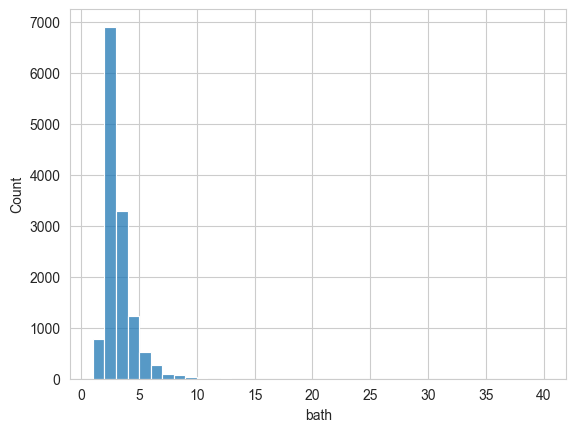

In [48]:
sn.histplot(df, x='bath', binwidth=1)

In [49]:
df7[df7['bath'] > df7['BHK']]

,location,total_sqft,bath,price,BHK,price_per_sqrt
84,EPIP Zone,1499.0,5.0,102.0,3,6804.536358
85,Hegde Nagar,3000.0,7.0,210.0,6,7000.000000
209,Padmanabhanagar,1736.0,6.0,190.0,4,10944.700461
370,Hebbal,2483.0,5.0,212.0,4,8538.058800
421,Budigere,1991.0,4.0,103.0,3,5173.279759
...,...,...,...,...,...,...
13048,Sarjapur Road,1984.0,4.0,148.0,3,7459.677419
13219,Laggere,1590.0,9.0,132.0,7,8301.886792
13229,Ambedkar Nagar,2395.0,4.0,150.0,3,6263.048017
13293,Sarjapur Road,2425.0,5.0,195.0,4,8041.237113


In [50]:
df8 = df7[df7['bath'] <= df7['BHK']]

In [51]:
df8.shape

(6199, 6)

In [52]:
df9 = df8.drop(['price_per_sqrt'], axis='columns')
df9.head()

,location,total_sqft,bath,price,BHK
0,Electronic City Phase II,1056.0,2.0,39.07,2
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2
6,Old Airport Road,2732.0,4.0,204.00,4
12,7th Phase JP Nagar,1000.0,2.0,38.00,2


# Model building

In [53]:
df10 = pd.get_dummies(df9).drop('location_other', axis='columns')
df10.head()

,total_sqft,bath,price,BHK,location_1st Block Jayanagar,location_1st Phase JP Nagar,location_2nd Phase Judicial Layout,location_2nd Stage Nagarbhavi,location_5th Block Hbr Layout,location_5th Phase JP Nagar,...,location_Vijayanagar,location_Vishveshwarya Layout,location_Vishwapriya Layout,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yelenahalli,location_Yeshwanthpur
0,1056.0,2.0,39.07,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1521.0,3.0,95.00,3,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1200.0,2.0,51.00,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,2732.0,4.0,204.00,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12,1000.0,2.0,38.00,2,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [54]:
inputs = df10.drop('price', axis='columns')
target = df10['price']

In [55]:
model_params = {
    'LinearRegression': {
        'model': LinearRegression(copy_X=True),
        'params': {
        }
    },
    'lasso_reg': {
        'model': Lasso(),
        'params': {
            'alpha': (1, 2, 25, 50),
            'max_iter': (50, 100, 150)
        }
    },
    'ridge_reg': {
        'model': Ridge(),
        'params': {
            'alpha': (1, 2, 25, 50),
            'max_iter': (50, 100, 150)
        }
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion': ('mse', 'friedman_mse'),
            'splitter': ('best', 'random')
        }
    },
}

In [56]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)

    clf.fit(inputs, target)  # training data

    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,LinearRegression,-1.039064e+15,{}
1,lasso_reg,6.293860e-01,"{'alpha': 1, 'max_iter': 50}"
2,ridge_reg,7.293019e-01,"{'alpha': 1, 'max_iter': 50}"
3,DecisionTreeRegressor,6.052809e-01,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [57]:
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2)

model = Ridge(alpha=1, max_iter=50)
model.fit(inputs, target)

Ridge(alpha=1, max_iter=50)

In [58]:
def predict_price(location: str, sqft: float, bath: int, bhk: int):
    loc_index = np.where(inputs.columns==f'location_{location}')[0][0]

    x = np.zeros(len(inputs.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk

    if loc_index >= 0:
        x[loc_index] = 1

    return model.predict([x])[0]

In [59]:
predict_price('1st Phase JP Nagar', 1000, 2, 2)

87.83216258653543

In [60]:
with open('home_prices_model.pickle', 'wb') as file:
    pickle.dump(model, file)

In [61]:
columns = {
    'data_columns': list(inputs.columns)
}

with open('columns.json', 'w') as file:
    file.write(json.dumps(columns))